Testing a toy example for demonstrating enhanced MAML in RL.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from itertools import combinations

import torch
from torch import nn
from torch import optim
from torch.autograd import grad
from higher import innerloop_ctx
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn import cluster
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import notebook_setup
import ppo, utils, meta
from ppo import DEVICE
from systems import CartPoleEnv, plot_cartpole
from systems import TanksPhysicalEnv, TanksFactory, plot_tanks

### Standard MAML training

In [2]:
def train(agent: ppo.PPO, tasks, n=10, losses=None, seed=None, lr_ini=None):
    """Pre-training model using higher-order gradients on per-task samples from `training_tasks`"""
    if seed is not None: torch.manual_seed(seed)
    model, opt = agent.policy, agent.optimizer
    og_lrs = []
    for pgroup in opt.param_groups:
        og_lrs.append(pgroup['lr'])
        if lr_ini is not None:
            pgroup['lr'] = lr_ini
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n)
    memory = ppo.Memory()
    for e in trange(n, leave=False, desc='MAML Initialization'):
        opti = optim.Adam(model.parameters(), **opt.defaults)
        for i, env in enumerate(tasks):
            with innerloop_ctx(model, opti, copy_initial_weights=False) as (fmodel, diffopt):

                agent.experience(memory, timesteps=k, env=env, policy=fmodel)
                agent.update(fmodel, memory, epochs=4, optimizer=diffopt, higher_optim=True)
                memory.clear()
                
                agent.experience(memory, timesteps=k, env=env, policy=fmodel)
                l = agent.update(fmodel, memory, optimizer=None)
                memory.clear()
                if losses is not None:
                    losses[i].append(l.item())

        opt.step()
        scheduler.step()
        opt.zero_grad()
    for pgroup, lr in zip(opt.param_groups, og_lrs):
        pgroup['lr'] = lr

def benchmark_train(agent, tasks, n=10, losses=None, seed=None):
    """Pre-training model on aggregated samples from `training_tasks`"""
    if seed is not None: torch.manual_seed(seed)
    model, opt = agent.policy, agent.optimizer
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n)
    memory = ppo.Memory()
    for _ in trange(n, leave=False, desc='Bench. Initialization'):
        for i, env in enumerate(tasks):

                agent.experience(memory, timesteps=k, env=env, policy=model)
                l = agent.update(model, memory, epochs=4, optimizer=opt, higher_optim=False)
                memory.clear()
                if losses is not None:
                    losses[i].append(l.item())

        opt.step()
        scheduler.step()
        opt.zero_grad()

In [3]:
def test(agent, n, env, losses=None, rewards=None, callback=None, track_higher_grads=False, seed=None):
    """Fine-tuning model on tasks contained in `evaluation_tasks`"""
    if seed is not None: torch.manual_seed(seed)
    model = agent.policy
    memory = ppo.Memory()
    opti = optim.Adam(model.parameters(), **agent.optimizer.defaults)
    with innerloop_ctx(model, opti, track_higher_grads=track_higher_grads) as (fmodel, diffopt):
        for e in trange(n, leave=False, desc='Testing'):

            agent.experience(memory, timesteps=k, env=env, policy=fmodel)
            agent.update(fmodel, memory, epochs=n_adapt, optimizer=diffopt, higher_optim=True)
            memory.clear()

            if losses is not None or rewards is not None:
                agent.experience(memory, timesteps=k*3, env=env, policy=fmodel)
                episodic_rewards = utils.cache_to_episodic_rewards([memory.rewards], [memory.is_terminals])
                l = agent.update(fmodel, memory, epochs=4, optimizer=None, higher_optim=True)
                memory.clear()
                if losses is not None: losses.append(l.item())
                if rewards is not None: rewards.append(np.nanmean(episodic_rewards))
            
            if callback is not None:
                callback(locals())
            

### Complementary MAML training

In [4]:
def initialize(agent, tasks, n=1, mode='fomaml', seed=None):
    if seed is not None: torch.manual_seed(seed)
    library, gradients, losses = [], [], []
    model, opt = agent.policy, agent.optimizer
    og_params = model.state_dict()
    memory = ppo.Memory()

    for i, env in tqdm(enumerate(tasks), total=len(tasks), desc='Initialization', leave=False):

        for e in trange(n, leave=False):
            
            if e == 0:
                opti = optim.Adam(model.parameters(), **agent.optimizer.defaults)
                library.append(og_params)
                filler = torch.ones_like if mode in ('maml', 'fomaml') else torch.zeros_like
                gradsi = [filler(p) for p in model.parameters()]
                gradients.append(gradsi)
                losses.append([])
            
            with innerloop_ctx(model, opti, track_higher_grads=True) as (fmodel, diffopt):

                # train on task
                fmodel.load_state_dict(library[i])
                agent.experience(memory, timesteps=k, env=env, policy=fmodel)
                agent.update(fmodel, memory, epochs=1, optimizer=diffopt, higher_optim=True)
                memory.clear()
                library[i] = fmodel.state_dict()
                
                agent.experience(memory, timesteps=k, env=env, policy=fmodel)
                l = agent.update(fmodel, memory, optimizer=None)
                memory.clear()
                losses[i].append(l.item())
                
                # get gradints
                gradsi = gradients[i]
                for j, (p0, p1) in enumerate(zip(fmodel.parameters(time=0), fmodel.parameters())):
                    if mode in ('maml', 'fomaml'):
                        gradsi[j] *= grad(p1.sum(), p0, retain_graph=True)[0]
                    elif mode == 'reptile':
                        gradsi[j].data += p1.data - p0.data

    model.load_state_dict(og_params)
    return library, gradients, losses

In [5]:
def ctrain(agent, n, memory, library, gradients, losses=None, mode='fomaml', lr_ini=None):
    """Create a new initialization of policy (and gradients) based in library and memory"""
    model, opt = agent.policy, agent.optimizer
    og_lrs = []
    for pgroup in opt.param_groups:
        og_lrs.append(pgroup['lr'])
        if lr_ini is not None:
            pgroup['lr'] = lr_ini
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n)
    for _ in trange(n, leave=False, desc='Training'):
        # Iterate over trained parameters, and gradients of parameters w.r.t parent params
        # Parameters in library are *trained* on tasks sampled from to population
        for i, (params, grads) in enumerate(zip(library, gradients)):
            # Here we get *test* gradients of trained params on the new task represented by the memory
            opti = optim.Adam(model.parameters(), **opt.defaults)
            # Create a functional version of model that tracks parameters over time as they are updated
            with innerloop_ctx(model, opti, track_higher_grads=False, copy_initial_weights=False) as (fmodel, diffopt):
                # Load parameters from library for evaluation
                fmodel.load_state_dict(params)
                # Update functional model
                agent.update(fmodel, memory, optimizer=diffopt, higher_optim=True)
                # Backpropagate gradients to original agent
                agent.update(fmodel, memory, optimizer=None)
        # TODO: Only need gradients between parameters before and after this step:
        # How? Make opt a diffopt. Have update() return loss for each params in library. Sum losses and feed then to
        # opt? No - each loss gradient needs to be multiplied with gradients between parameters, summing bundles them
        # toegether. (dl1)
        opt.step()  # copy_initial_weights=False accumulates gradients in model.parameters()
        scheduler.step()
        opt.zero_grad()
    for pgroup, lr in zip(opt.param_groups, og_lrs):
        pgroup['lr'] = lr

def ctest(agent, n, env, losses=None, rewards=None, callback=None, library=None, gradients=None, tasks=None):
    def store(lvars):
#         i = lvars.get('i')
#         fmodel = lvars.get('fmodel')
#         if library is not None:
#             library[i] = fmodel.state_dict()
#             gradients[i] = utils.get_gradients(fmodel.parameters(), fmodel.parameters(time=0))
        if callback is not None: callback(lvars)
    test(agent, n, env, losses=losses, rewards=rewards, callback=store, track_higher_grads=False)

In [6]:
def distance(memory, policy, params1, params2):
    """Similarity between two policies based on probabilities of same experience"""
    og_params = policy.state_dict()
    s = torch.tensor(memory.states).float().to(DEVICE)
    a = torch.tensor(memory.actions).float().to(DEVICE)

    policy.load_state_dict(params1)
    logprobs0, _, _ = policy.evaluate(s, a)
    p0 = torch.exp(logprobs0).detach()

    policy.load_state_dict(params2)
    logprobs1, _, _ = policy.evaluate(s, a)
    p1 = torch.exp(logprobs1).detach()

    dist = jensenshannon(p0.cpu(), p1.cpu())
    policy.load_state_dict(og_params)
    return dist, dist

def prune_library(library, agent, memory, max_library_size=10, seed=None):
    """Rank policies with most divergent behavior from other policies"""
    random = np.random.RandomState(seed) if seed is not None else seed
    policy = agent.policy
    divmat = np.zeros((len(library), len(library)))
    for p1, p2 in combinations(range(len(library)), 2):
        divmat[p1, p2], divmat[p2, p1] = distance(memory, policy, library[p1], library[p2])
    # https://sklearn.org/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering
    affmat = np.exp(- divmat**2 / 2)
    size = min(max_library_size, len(library))  # size of divergence matrix
    if size < len(library):
        clusterer = cluster.SpectralClustering(size, affinity='precomputed')
        clusters = clusterer.fit_predict(affmat)
        keep, clusters_added = [], []
        for i, c in enumerate(clusters):
            if c not in clusters_added:
                keep.append(i)
                clusters_added.append(c)
        if len(keep) < size:
            left = [i for r in range(len(library)) if i not in keep]
            keep.extend(random.choice(left, size - len(keep)))
    else:
        keep = np.argsort(np.sum(divmat, axis=1))[::-1][:size]
    idx = np.ix_(keep, keep)  # generate indices to select range of axes
    return [library[k] for k in keep], divmat[idx], keep

def rank_library(library, agent, memory):
    """Sort policies by expected returns on a memory of experiences (descending)"""
    og_params = agent.policy.state_dict()
    returns = torch.tensor(memory.returns).float().to(DEVICE).detach()
    truncate = len(returns)
    # returns = (returns - returns.mean()) / (returns.std() + 1e-5)
    states = torch.tensor(memory.states[:truncate]).float().to(DEVICE).detach()
    actions = torch.tensor(memory.actions[:truncate]).float().to(DEVICE).detach()
    vals = []
    for params in library:
        agent.policy.load_state_dict(params)
        logp, _, _ = agent.policy.evaluate(states, actions)
        p = torch.exp(logp)
        vals.append(torch.sum(p * returns).item())
    agent.policy.load_state_dict(og_params)
    return np.argsort(vals)[::-1], np.asarray(vals)

# Experiments

In [12]:
n_training_tasks = 5
# training_tasks = list(range(n_training_tasks))  # random seeds for generating task parameters
training_tasks = [0,1,2,3,4]
evaluation_task = 6
k = 300        # number of examples per task
alpha = 0.002   # global learning rate
alpha_ini = 0.02 # initialization lr for our approach
n_adapt = 5
n_train = 10
n_test = 20
max_library_size = 6
rank_threshold = 0.25
env_name = 'Tanks'

In [13]:
if env_name=='CartPole':

    def get_task(seed=None, randomize=True):
        env = CartPoleEnv(seed)
        return env.randomize() if randomize else env

    def make_model(seed=None):
        return ppo.PPO(
            env=None,
            policy=ppo.ActorCriticDiscrete,
            state_dim=4,
            action_dim=2,
            n_latent_var=50,
            lr=alpha,
            seed=seed)

elif env_name=='Tanks':
    
    faults = [
        dict(valves_min=np.asarray([0,0.5,0,0,0,0])),
        dict(valves_min=np.asarray([0,0,0.5,0,0,0])),
        dict(valves_min=np.asarray([0,0,1.,0,0,0])),
        dict(valves_min=np.asarray([0.25,0,0,0,0,0])),
        dict(valves_min=np.asarray([0.5,0,0,0,0,0])),
        dict(valves_min=np.asarray([0.25,0,0,0,0,0])),
        dict(valves_min=np.asarray([0,0,0,0,0.25,0])),
    ]

    def get_task(seed=None, randomize=False):
        if seed is None:
            env = TanksPhysicalEnv(TanksFactory(), seed=seed)
        else:
            env = TanksPhysicalEnv(TanksFactory(**faults[seed]), seed=seed)
        return env if not randomize else env.randomize()

    def make_model(seed=None):
        return ppo.PPO(
            env=None,
            policy=ppo.ActorCriticDiscrete,
            state_dim=6,
            action_dim=6,
            n_latent_var=50,
            lr=alpha,
            seed=seed)

In [ ]:
a = make_model()
e = get_task()
a.env = e
r = a.learn(20000, 300)
plt.plot(r)

### Standard MAML testing

In [ ]:
class TE(TanksPhysicalEnv):
    def reset(self):
        self.t = 0.
        self.x = np.ones(6)
        return self.x
e = TE(TanksFactory())
e.tanks.engines[:] = 0.001
e.reset()
e.x = np.ones_like(e.tanks.heights)
# done = False
# while not done:
#     s, r, done, _ = e.step(np.zeros(6))
#     print(s)
plot_tanks(e, a)

In [ ]:
agent = make_model()
bench = make_model()
bench.policy.load_state_dict(agent.policy.state_dict())

losses_train = [[] for _ in training_tasks]
losses_bench_train = [[] for _ in training_tasks]
losses_test = [[] for _ in evaluation_tasks]
losses_bench_test = [[] for _ in evaluation_tasks]

for epoch in trange(10, leave=False):
    train(agent, 10, losses_train)
    benchmark_train(bench, 10, losses_bench_train)
    test(agent, losses=losses_test)
    test(bench, losses=losses_bench_test)

In [ ]:
# Loss perfomance
for t, tb in zip(losses_test, losses_bench_test):
    plt.plot(t, label='Test')
    plt.plot(tb, label='Bench')
plt.grid(True)
plt.legend()

In [ ]:
# Plotting actual outputs
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_cartpole(get_task(evaluation_tasks[-1]), agent, legend=False)
plt.subplot(1,2,2)
test(agent, evaluation_tasks[-1], losses=None, callback=lambda args: plot_cartpole(args.get('env'), args.get('agent')))
plt.tight_layout()

### Complementary MAML testing

#### Post-fault adaption

In [ ]:
seeds = [0, 1, 2]

r_test = [[] for _ in seeds]
r_bench_test = [[] for _ in seeds]
r_maml_test = [[] for _ in seeds]


for i, seed in tqdm(enumerate(seeds), total=len(seeds), leave=False, desc='Seed'):
    torch.manual_seed(seed)
    agent = make_model()
    bench = make_model()
    maml = make_model()
    bench.policy.load_state_dict(agent.policy.state_dict())
    maml.policy.load_state_dict(agent.policy.state_dict())

    library, gradients, losses_init = initialize(agent, list(map(get_task, training_tasks)), n=n_train, seed=seed)
    # benchmark_train(bench, list(map(get_task, training_tasks)), n=n_train, seed=seed)
    train(maml, list(map(get_task, training_tasks)), n=n_train, seed=seed)

    memory = ppo.Memory()
    
    # get performance prior to adaption
    for ag, reward in zip((agent, bench, maml), (r_test, r_bench_test, r_maml_test)):
        env = get_task(evaluation_task)
        torch.manual_seed(seed)
        ag.experience(memory, k, env, ag.policy)
        episodic_rewards = utils.cache_to_episodic_rewards([memory.rewards], [memory.is_terminals])
        reward[i].append(np.nanmean(episodic_rewards))
        memory.clear()
    
    env = get_task(evaluation_task)
    agent.experience(memory, k, env, agent.policy)
    
    library, divmat, pidx = prune_library(library, agent, memory, max_library_size=max_library_size)
    vidx, vals = rank_library(library, agent, memory)
    maxv, minv = max(vals), min(vals)
    threshold_val = maxv - rank_threshold * (maxv - minv)
    library = [param for i, param in enumerate(library) if vals[i] >= threshold_val]
    gradients = [grads for i, grads in enumerate(gradients) if vals[i] >= threshold_val]
    # plt.bar(np.arange(len(vals)), vals[vidx], tick_label=vidx)
    # plt.axhline(threshold_val, linestyle=':')
    # print('Top %d params selected' % len(library))

    # Pre-train
    ctrain(agent, n_train, memory, library, gradients, lr_ini=alpha_ini)  # buffered experiences
    
    test(agent, n_test, env, rewards=r_test[i], seed=seed) # fomaml doesn't need to store grads
    test(bench, n_test, env, rewards=r_bench_test[i], seed=seed)
    test(maml, n_test, env, rewards=r_maml_test[i], seed=seed)

Seed:   0%|          | 0/3 [00:00<?, ?it/s]

Initialization:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

MAML Initialization:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Initialization:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

MAML Initialization:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Initialization:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Reward perfomance
t, t_s = np.mean(r_test, axis=0), np.std(r_test, axis=0)
tb, tb_s = np.mean(r_bench_test, axis=0), np.std(r_bench_test, axis=0)
tm, tm_s = np.mean(r_maml_test, axis=0), np.std(r_maml_test, axis=0)

l, = plt.plot(t, label='Ours')
plt.fill_between(np.arange(len(t)), t - t_s, t + t_s, alpha=0.3, color=l.get_color())
l, = plt.plot(tb, label='Vanilla')
plt.fill_between(np.arange(len(tb)), tb - tb_s, tb + tb_s, alpha=0.3, color=l.get_color())
l, = plt.plot(tm, label='MAML')
plt.fill_between(np.arange(len(tm)), tm - tm_s, tm + tm_s, alpha=0.3, color=l.get_color())

plt.grid(True)
plt.legend()

#### Varying ranking threshold

In [14]:
seeds = [0, 1, 2]
thresholds = [0, 0.25, 0.5, 0.75, 1.0]
r_thresh = [[[] for _ in seeds] for _ in thresholds] # lists of results per seed, per threshold

for i, seed in tqdm(enumerate(seeds), total=len(seeds), leave=False, desc='Seed'):
    agent = make_model(seed)
    library, gradients, losses_init = initialize(agent, list(map(get_task, training_tasks)), n=n_train, seed=seed)
    memory = ppo.Memory()
    env = get_task(evaluation_task)
    agent.experience(memory, k, env, agent.policy)
    episodic_rewards = utils.cache_to_episodic_rewards([memory.rewards], [memory.is_terminals])
    for r in r_thresh:
        # fill same seed for each threshold with initial rewards
        r[i].append(np.nanmean(episodic_rewards))
    
    vidx, vals = rank_library(library, agent, memory)
    maxv, minv = max(vals), min(vals)
    for r, thresh in zip(r_thresh[i], thresholds):
        threshold_val = maxv - thresh * (maxv - minv)
        library_ = [param for i, param in enumerate(library) if vals[i] >= threshold_val]
        gradients_ = [grads for i, grads in enumerate(gradients) if vals[i] >= threshold_val]
        
        # Pre-train
        ctrain(agent, n_train, memory, library_, gradients_, lr_ini=alpha_ini)  # buffered experiences

        test(agent, n_test, env, rewards=r, seed=seed) # fomaml doesn't need to store grads
        
        

Seed:   0%|          | 0/3 [00:00<?, ?it/s]

Initialization:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Initialization:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Initialization:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

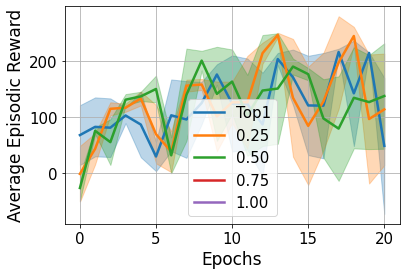

In [15]:
# Reward perfomance
for rewards, thresh in zip(r_thresh, thresholds):
    r, r_s = np.mean(rewards, axis=0), np.std(rewards, axis=0) # mean over seeds
    l, = plt.plot(r, label= 'Top1' if thresh==0 else '%.2f' % thresh)
    plt.fill_between(np.arange(len(r)), r - r_s, r + r_s, alpha=0.3, color=l.get_color())

plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Average Episodic Reward')
plt.legend()

#### Library pruning

In [68]:
seeds = [0, 1, 2]
library_sizes = [2, 4, 8]
r_lib = [[[] for _ in seeds] for _ in library_sizes]
divmats = [[] for _ in library_sizes]
threshold = 0.25
task_params = [0,1,2,3,4,5,7,8]

for i, seed in tqdm(enumerate(seeds), total=len(seeds), leave=False, desc='Seed'):
    np_random = np.random.RandomState(seed)
    agent = make_model(seed)
    library, gradients, _ = initialize(agent, list(map(get_task, task_params)), n=n_train, seed=seed)
    
    env = get_task(evaluation_task)
    memory = ppo.Memory()
    agent.experience(memory, k, env, agent.policy)
    episodic_rewards = utils.cache_to_episodic_rewards([memory.rewards], [memory.is_terminals])
    for r in r_lib:
        # fill same seed for each libsize with initial rewards
        r[i].append(np.nanmean(episodic_rewards))
    
    for j, libsize in enumerate(tqdm(library_sizes, leave=False, desc='Lib Size')):
        # Pruning
        library_, divmat, pidx = prune_library(library, agent, memory, max_library_size=libsize)
        gradients_ = [gradients[k] for k in pidx]
        divmats[j].append(divmat)
        # Rank thresholding
        vidx, vals = rank_library(library_, agent, memory)
        maxv, minv = max(vals), min(vals)
        threshold_val = maxv - threshold * (maxv - minv)
        library_ = [param for i, param in enumerate(library_) if vals[i] >= threshold_val]
        gradients_ = [grads for i, grads in enumerate(gradients_) if vals[i] >= threshold_val]
        # Testing
        ctrain(agent, n_train, memory, library_, gradients_, lr_ini=alpha_ini)  # buffered experiences
        test(agent, n_test, env, rewards=r_lib[j][i], seed=seed) # fomaml doesn't need to store grads

Seed:   0%|          | 0/3 [00:00<?, ?it/s]

Initialization:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Lib Size:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Initialization:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Lib Size:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Initialization:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Lib Size:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


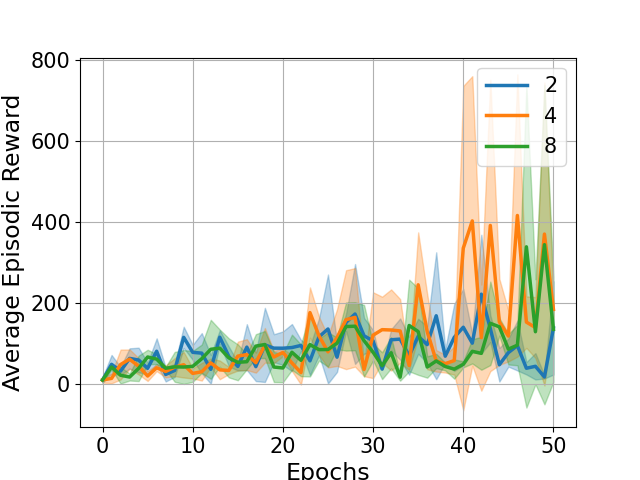

In [69]:
# Reward perfomance
for rewards, divmat, libsize in zip(r_lib, divmats, library_sizes):
    r, r_s = np.mean(rewards, axis=0), np.std(rewards, axis=0) # mean over seeds
    l, = plt.plot(r, label='%d' % libsize)
    plt.fill_between(np.arange(len(r)), r - r_s, r + r_s, alpha=0.3, color=l.get_color())

plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Average Episodic Reward')
plt.legend()

In [70]:
dmin, dmax = np.min([np.min(d) for d in divmats]), np.max([np.max(d) for d in divmats])
for rewards, divmat, libsize, ax in zip(r_lib, divmats, library_sizes, plt.subplots(1, len(divmats), figsize=(9, 3))[1]):
    m, s = np.mean(divmat, axis=0), np.std(divmat, axis=0) # mean over seeds
    im = ax.matshow(m, vmin=dmin, vmax=dmax)
    ax.grid()
    ax.axis('off')

plt.gcf().subplots_adjust(right=0.9)
cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])
plt.gcf().colorbar(im, cax=cbar_ax)

<IPython.core.display.Javascript object>

In [ ]:
# TODO:
# How better than MAML?
# [x] Compare threshold vs. only selecting best policy
# [x] Compare vs vanilla RL (no initialization)

#### Understanding pruning

In [19]:
env = get_task(seed=0, randomize=False)
a1 = make_model(seed=0)
a1.env = env
r1 = a1.learn(20000, 500)

env = get_task(seed=0, randomize=False)
env.force_mag *= -1
a2 = make_model(seed=0)
a2.env = env
r2 = a2.learn(20000, 500)

env = get_task(seed=0, randomize=True)
a3 = make_model(seed=0)
a3.env = env
r3 = a3.learn(20000, 500)
m = ppo.Memory()
a3.experience(memory, k, env, a3.policy)

print('env 1 with reversed forces, envs 2 & 3 with normal forces')

print('3 v. 1:%.3f' % distance(memory, a3.policy, a3.policy.state_dict(), a1.policy.state_dict())[0])
print('3 v. 2:%.3f' % distance(memory, a3.policy, a3.policy.state_dict(), a2.policy.state_dict())[0])

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

env 1 with reversed forces, envs 2 & 3 with normal forces
3 v. 1:0.102
3 v. 2:0.411


#### Consolidation over time

In [ ]:
# Plotting actual outputs
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_cartpole(get_task(evaluation_tasks[-1]), agent, legend=False)
plt.subplot(1,2,2)
test(agent, evaluation_tasks[-1], losses=None, callback=lambda args: plot_cartpole(args.get('env'), args.get('agent')))
plt.tight_layout()